# Pipeline:

- Pipeline Diagram
- Step 1: Data Loading & Cleaning
    - Figure 1: Distribution of Job Title Synonyms in O*NET (Long-Tailed Synonym Structure)
- Step 2: Train / Val / Test split by column "O*NET-SOC Code" (SOC Code)
- Step 3: Shared corpus + TF-IDF baseline (fixed bug)
- Step 4: Pretrained SBERT index (no fine-tuning)
- Step 5: Build training examples & Fine-tune SBERT
- Step 6: Fine-tuned SBERT index (same corpus)
- Step 7: Evaluation (Seen → Canonical, focusing on solving Research Question 2)
- Step 8: Evaluation (Unseen → Seen, relating to solving Research Question 1)
- Step 9: Column "O*NET-SOC Code" Taxonomy-based Evaluation
- Step 10: Failure Case Analysis
- Step 11: Ablation Study (SBERT-pre vs SBERT-fine_tuning)
- Step 12: Hyperparameter Search
- Step 13: Computational Cost / Reproducibility
- Step 14: Summarize the Results (5 Tables + 2 Graphs + 1 Pipeline Diagram)
    - Table 1 Seen→Canonical: Retrieval Performance (Quantitative)
    - Table 2 Unseen→Seen: SOC Major-Group Accuracy
    - Table 3 Failure Case Samples (short version)
    - Table 4 Computational Efficiency
    - Table 5: Model Performance Across Different Training Configurations
    - Figure 2: t-SNE/UMAP of job-title embeddings
    - Figure 3: Bar chart of SOC accuracy for unseen queries
    - Pipeline Diagram Again

*Note: All experiments were conducted on a single NVIDIA RTX 4070 GPU with a total runtime of 3.5 hours. The code also supports CPU execution.*

# Pipeline Diagram:

```mermaid
flowchart LR
    A["Load O*NET Alt Titles Dataset"] --> B["Clean & Normalize Titles"]
    B --> C["Train/Val/Test Split by SOC Code"]

    C --> D1["TF-IDF Vectorizer"]
    C --> D2["SBERT Pretrained Embeddings"]
    C --> D3["SBERT Fine-tuning on Title Pairs"]

    D1 --> E1["FAISS / Matrix Index"]
    D2 --> E2["FAISS Index"]
    D3 --> E3["FAISS Index"]

    E1 --> F1["Seen→Canonical Eval (P@10, MRR)"]
    E2 --> F1
    E3 --> F1

    E1 --> F2["Unseen to Seen SOC Evaluation"]
    E2 --> F2
    E3 --> F2

    F2 --> G1["Failure Case Analysis"]
    F2 --> G2["Ablation: Negatives, Epochs, Batch Size"]

    G2 --> H1["Compute & Report Runtime (Encoding + Evaluation)"]
    H1 --> I["Tables & Graphs (Tables 1-5, t-SNE, SOC Bar Plot)"]
    I --> J["Results & Discussion"]


# Step 1: Data Loading & Cleaning

- **Data source**: The O*NET database contains a rich set of variables that describe work, worker characteristics, and skill requirements.
    - https://www.onetcenter.org/database.html#all-files:~:text=All%20Files-,O*NET%2030.0%20Database,in%20the%20O*NET%20core%20database%2C%20in%20one%20convenient%20ZIP%20archive.,-Excel

In [1]:
# All the packages for the project:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader
import torch

import faiss

# Config
DATA_PATH = "Alternate Titles.xlsx"    
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

def clean_title(text: str) -> str:
    """Basic text cleaning for job titles."""
    if not isinstance(text, str):
        return ""
    text = text.strip().lower()
    return text

def set_torch_deterministic(seed: int = 42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_torch_deterministic(RANDOM_SEED)

In [102]:
# Load Excel
DATA_PATH = "Alternate Titles.xlsx" 
df = pd.read_excel(DATA_PATH)

# Check required columns
required_cols = {"Title", "Alternate Title", "O*NET-SOC Code"}
if not required_cols.issubset(df.columns):
    raise ValueError(f"Dataset must contain columns: {required_cols}")

# Keep only rows with non-null Alternate Title
df = df[~df["Alternate Title"].isna()].copy()

# Clean titles
df["title_clean"] = df["Title"].apply(clean_title)
df["alt_title_clean"] = df["Alternate Title"].apply(clean_title)

# Drop rows where cleaning produced empty strings
df = df[(df["title_clean"] != "") & (df["alt_title_clean"] != "")].copy()
display(df.head())
print(f"Total usable pairs after cleaning + dedup: {df.shape[0]}")

,O*NET-SOC Code,Title,Alternate Title,Short Title,Source(s),title_clean,alt_title_clean
0,11-1011.00,Chief Executives,Aeronautics Commission Director,NaN,08,chief executives,aeronautics commission director
1,11-1011.00,Chief Executives,Agency Owner,NaN,10,chief executives,agency owner
2,11-1011.00,Chief Executives,Agricultural Services Director,NaN,08,chief executives,agricultural services director
3,11-1011.00,Chief Executives,Arts and Humanities Council Director,NaN,08,chief executives,arts and humanities council director
4,11-1011.00,Chief Executives,Bank President,NaN,09,chief executives,bank president


Total usable pairs after cleaning + dedup: 56495


#### **Short Illustration of the Columns:**
- ***Title*** refers to the canonical ***O*NET occupation***, while ***Alternate Title*** contains real-world synonyms commonly seen in job postings, each ***Title*** pair is linked to an *O*NET- Standard Occupational Classification (SOC)  Code. The first 2 digits of the ***O*NET-SOC code***, indicating the high-level occupational family (e.g., “15” = Computer and Mathematical Occupations) based on the U.S. Bureau of Labor Statistics SOC Manual (2018).
- ***title_clean*** and ***alt_title_clean***: These two cleaned columns are the actual inputs to all embedding models (TF-IDF, SBERT-pre, SBERT-ft) and are used throughout the entire pipeline.
  
**Reference:**
- Bureau of Labor Statistics. (2018). Standard Occupational Classification (SOC) Manual. U.S. Department of Labor. https://www.bls.gov/soc/2018/

,O*NET-SOC Code,Title,Alternate Title,Short Title,Source(s),title_clean,alt_title_clean,soc_major_group
0,11-1011.00,Chief Executives,Aeronautics Commission Director,NaN,08,chief executives,aeronautics commission director,11
1,11-1011.00,Chief Executives,Agency Owner,NaN,10,chief executives,agency owner,11
2,11-1011.00,Chief Executives,Agricultural Services Director,NaN,08,chief executives,agricultural services director,11



Basic Dataset Summary:
Total usable pairs after cleaning + dedup: 56495
Unique SOC codes: 1,016
Unique Canonical Titles: 1,016
Unique Alternate Titles: 46,087

Alternate Titles per SOC Occupation:
Mean:   55.61
Median: 36.00
Max:    2750.00


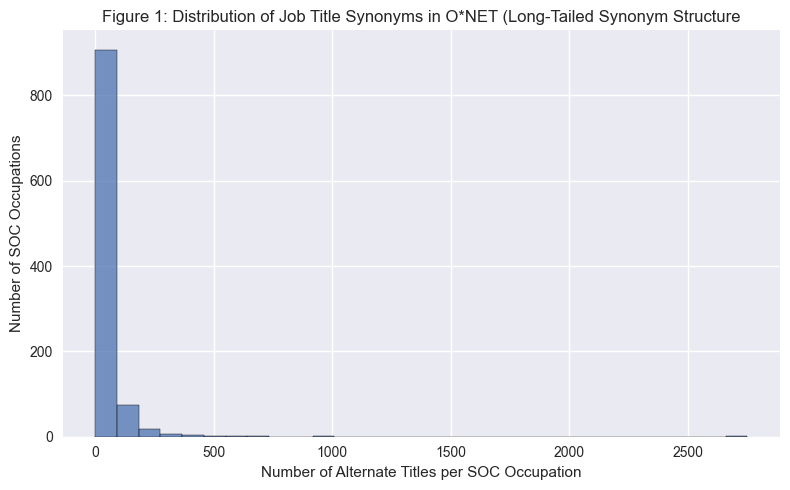

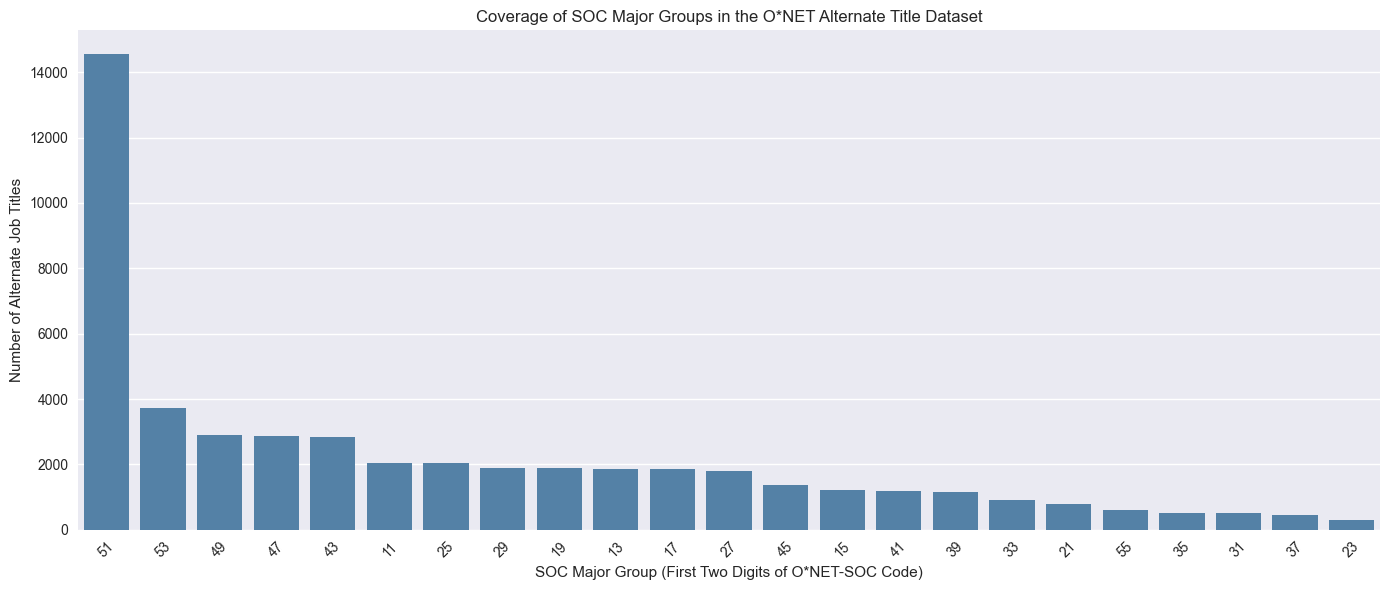

In [116]:
display(df.head(3))
# Basic summary statistics
print("\nBasic Dataset Summary:")
print(f"Total usable pairs after cleaning + dedup: {df.shape[0]}")
print(f"Unique SOC codes: {df['O*NET-SOC Code'].nunique():,}")
print(f"Unique Canonical Titles: {df['title_clean'].nunique():,}")
print(f"Unique Alternate Titles: {df['alt_title_clean'].nunique():,}")

# Extract SOC major group (first 2 digits)
df["soc_major_group"] = df["O*NET-SOC Code"].str.slice(0, 2)

# Count alternate titles per SOC occupation
alts_per_soc = df.groupby("O*NET-SOC Code")["alt_title_clean"].nunique()

print("\nAlternate Titles per SOC Occupation:")
print(f"Mean:   {alts_per_soc.mean():.2f}")
print(f"Median: {alts_per_soc.median():.2f}")
print(f"Max:    {alts_per_soc.max():.2f}")

# Plot 1: Distribution of alternate titles per SOC code 
plt.figure(figsize=(8, 5))
sns.histplot(alts_per_soc, bins=30, kde=False)
plt.xlabel("Number of Alternate Titles per SOC Occupation")
plt.ylabel("Number of SOC Occupations")
plt.title("Figure 1: Distribution of Job Title Synonyms in O*NET (Long-Tailed Synonym Structure")
plt.tight_layout()
plt.show()

# Plot 2: Major group coverage (important for RQ1)
soc_group_counts = df.groupby("soc_major_group")["alt_title_clean"].nunique().sort_values(ascending=False)

plt.figure(figsize=(14, 6))
sns.barplot(x=soc_group_counts.index, y=soc_group_counts.values, color="steelblue")
plt.xlabel("SOC Major Group (First Two Digits of O*NET-SOC Code)")
plt.ylabel("Number of Alternate Job Titles")
plt.title("Coverage of SOC Major Groups in the O*NET Alternate Title Dataset")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Step 2: Train/Val/Test split by column "O*NET-SOC Code" (SOC Code)

In [3]:
def split_by_soc(df: pd.DataFrame, test_size=0.2, val_size=0.1, seed=42):
    codes = df["O*NET-SOC Code"].unique()
    train_codes, test_codes = train_test_split(codes, test_size=test_size, random_state=seed)
    train_codes, val_codes = train_test_split(train_codes, test_size=val_size, random_state=seed)

    train_df = df[df["O*NET-SOC Code"].isin(train_codes)].copy()
    val_df = df[df["O*NET-SOC Code"].isin(val_codes)].copy()
    test_df = df[df["O*NET-SOC Code"].isin(test_codes)].copy()
    return train_df, val_df, test_df


train_df, val_df, test_df = split_by_soc(df, test_size=0.2, val_size=0.1, seed=RANDOM_SEED)
print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))


Train: 40555 Val: 3487 Test: 12453


# Step 3: Shared corpus + TF-IDF baseline (fixed bug)

In [4]:
# Shared corpus: ALL unique titles in the whole dataset (canonical + alternate)
corpus_titles = pd.concat(
    [df["title_clean"], df["alt_title_clean"]]
).drop_duplicates().tolist()

len(corpus_titles)

# ---- TF-IDF baseline over the full corpus ----
tfidf_vectorizer = TfidfVectorizer(
    analyzer="word",
    ngram_range=(1, 2),
    min_df=2
)

tfidf_matrix = tfidf_vectorizer.fit_transform(corpus_titles)

def tfidf_retrieve_similar(query_title: str, top_k: int = 10):
    q_clean = clean_title(query_title)
    q_vec = tfidf_vectorizer.transform([q_clean])
    sims = cosine_similarity(q_vec, tfidf_matrix)[0]
    best_idx = np.argsort(-sims)[:top_k]
    return [(corpus_titles[i], float(sims[i])) for i in best_idx]

# Quick sanity check
tfidf_retrieve_similar("llm architect", top_k=5)


[('architect', 1.0),
 ('architect manager', 0.8555311723029997),
 ('computer architect', 0.7783792986755671),
 ('information architect', 0.7719499706499509),
 ('design architect', 0.7579247575025239)]

# Step 4: Pretrained SBERT index (no fine-tuning)

In [5]:
# Pretrained SBERT (no fine-tuning)  
sbert_pretrained_name = "all-MiniLM-L6-v2"
sbert_pre = SentenceTransformer(sbert_pretrained_name)

# Encode corpus titles
emb_pre = sbert_pre.encode(corpus_titles, convert_to_numpy=True, show_progress_bar=True)

# Normalize for cosine similarity
emb_pre_norm = emb_pre / (np.linalg.norm(emb_pre, axis=1, keepdims=True) + 1e-12)

d_pre = emb_pre_norm.shape[1]
index_pre = faiss.IndexFlatIP(d_pre)
index_pre.add(emb_pre_norm)

def sbert_pre_retrieve_similar(query_title: str, top_k: int = 10):
    q_clean = clean_title(query_title)
    q_vec = sbert_pre.encode([q_clean], convert_to_numpy=True)
    q_vec_norm = q_vec / (np.linalg.norm(q_vec, axis=1, keepdims=True) + 1e-12)
    scores, idxs = index_pre.search(q_vec_norm, top_k)
    results = []
    for score, idx in zip(scores[0], idxs[0]):
        results.append((corpus_titles[idx], float(score)))
    return results

# Sanity check
sbert_pre_retrieve_similar("llm architect", top_k=5)


Batches:   0%|          | 0/1472 [00:00<?, ?it/s]

[('architect manager', 0.7351635098457336),
 ('architect', 0.729507327079773),
 ('building architect', 0.6905176639556885),
 ('licensed architect', 0.6789504289627075),
 ('design architect', 0.6780273914337158)]

# Step 5: Build training examples & Fine-tune SBERT

In [6]:
# Build contrastive training examples from train_df  
def build_sbert_training_examples(train_df: pd.DataFrame,
                                  neg_sample_size: int = 5000,
                                  seed: int = 42):
    rng = np.random.default_rng(seed)

    # Positive pairs: (canonical, alternate)
    pos_examples = []
    for _, row in train_df.iterrows():
        pos_examples.append(
            InputExample(
                texts=[row["title_clean"], row["alt_title_clean"]],
                label=1.0
            )
        )

    # Negative pairs: mismatched titles from different SOC codes
    neg_examples = []
    n = len(train_df)
    neg_sample_size = min(neg_sample_size, n)
    sampled = train_df.sample(neg_sample_size, random_state=seed)

    titles = list(sampled["title_clean"])
    alts   = list(sampled["alt_title_clean"])
    codes  = list(sampled["O*NET-SOC Code"])

    for i in range(len(sampled)):
        j = rng.integers(0, len(sampled))
        if codes[i] != codes[j]:
            neg_examples.append(
                InputExample(
                    texts=[titles[i], alts[j]],
                    label=0.0
                )
            )

    return pos_examples + neg_examples


train_examples = build_sbert_training_examples(train_df,
                                               neg_sample_size=5000,
                                               seed=RANDOM_SEED)
len(train_examples)


45516

In [7]:
# Fine-tune SBERT  
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

sbert_ft_name = "all-MiniLM-L6-v2"
sbert_ft = SentenceTransformer(sbert_ft_name, device=device)

train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=32)
train_loss = losses.CosineSimilarityLoss(sbert_ft)

num_epochs = 1
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1)

sbert_ft.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=num_epochs,
    warmup_steps=warmup_steps,
    show_progress_bar=True
)

# Optional: save model
sbert_ft.save("jobtitle_sbert_finetuned")


Using device: cuda


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss
500,0.094400
1000,0.055000


# Step 6: Fine-tuned SBERT index (same corpus)

In [8]:
# Encode corpus titles with fine-tuned model
emb_ft = sbert_ft.encode(corpus_titles, convert_to_numpy=True, show_progress_bar=True)
emb_ft_norm = emb_ft / (np.linalg.norm(emb_ft, axis=1, keepdims=True) + 1e-12)

d_ft = emb_ft_norm.shape[1]
index_ft = faiss.IndexFlatIP(d_ft)
index_ft.add(emb_ft_norm)

def sbert_ft_retrieve_similar(query_title: str, top_k: int = 10):
    q_clean = clean_title(query_title)
    q_vec = sbert_ft.encode([q_clean], convert_to_numpy=True)
    q_vec_norm = q_vec / (np.linalg.norm(q_vec, axis=1, keepdims=True) + 1e-12)
    scores, idxs = index_ft.search(q_vec_norm, top_k)
    results = []
    for score, idx in zip(scores[0], idxs[0]):
        results.append((corpus_titles[idx], float(score)))
    return results

# Sanity check
sbert_ft_retrieve_similar("llm architect", top_k=5)


Batches:   0%|          | 0/1472 [00:00<?, ?it/s]

[('technical architect', 0.9790340662002563),
 ('architect', 0.9778622388839722),
 ('building architect', 0.977362334728241),
 ('platform architect', 0.9773457646369934),
 ('architect specialist', 0.9767193794250488)]

# Step 7: Evaluation (Seen → Canonical, focusing on solving Research Question 2)

- **Research Question 2 (Seen → Seen):**
    - When **the input job title appears in the dataset** as an alternate titles, how accurately can the model **retrieve the correct canonical job title**?


In [9]:
def evaluate_seen_seen(test_df: pd.DataFrame, retrieve_fn, top_k: int = 10):
    """
    test_df: contains columns 'title_clean' (canonical), 'alt_title_clean' (query)
    retrieve_fn: function(query_str, top_k) -> list[(title, score)]
    """
    hits_at_k = 0
    mrr_sum = 0.0
    n = len(test_df)

    for _, row in test_df.iterrows():
        query = row["alt_title_clean"]       # input: alternate title
        true_canonical = row["title_clean"]  # target: canonical

        results = retrieve_fn(query, top_k=top_k)
        titles_only = [t for t, _ in results]

        try:
            rank = titles_only.index(true_canonical) + 1  # 1-based rank
            hits_at_k += 1
            mrr_sum += 1.0 / rank
        except ValueError:
            # canonical not in top-k
            pass

    precision_at_k = hits_at_k / n
    mrr = mrr_sum / n
    return precision_at_k, mrr


# --- Evaluate all three models on Seen → Canonical ---
p_tfidf, mrr_tfidf = evaluate_seen_seen(test_df, tfidf_retrieve_similar, top_k=10)
print("TF-IDF     P@10:", p_tfidf, "MRR:", mrr_tfidf)

p_pre, mrr_pre = evaluate_seen_seen(test_df, sbert_pre_retrieve_similar, top_k=10)
print("SBERT-pre  P@10:", p_pre, "MRR:", mrr_pre)

p_ft, mrr_ft = evaluate_seen_seen(test_df, sbert_ft_retrieve_similar, top_k=10)
print("SBERT-ft   P@10:", p_ft, "MRR:", mrr_ft)


TF-IDF     P@10: 0.020476993495543244 MRR: 0.004278021870168352
SBERT-pre  P@10: 0.07532321528948847 MRR: 0.016412855192667223
SBERT-ft   P@10: 0.06713241789127118 MRR: 0.016786322923398298


- These numbers directly answer **Research Question 2**:

    - When **the input job title appears in the dataset** as an alternate title, how accurately can the model **retrieve the correct canonical job title**?

# Step 8: Evaluation (Unseen → Seen, relating to solving Research Question 1)
- Research Question 1 (Unseen → Seen):
    - When the **input job title does not appear in the dataset** (e.g., "LLM Architect"), can the model **still map it to appropriate existing titles in the dataset** (e.g., "NLP Engineer", "Machine Learning Engineer"), showing that it “understands” LLM/NLP/ML semantics?

In [10]:
queries_unseen = [
    "llm architect",
    "generative ai engineer",
    "foundation model specialist",
    "mlops architect",
    "large language model engineer"
]

for q in queries_unseen:
    print(f"\n==============================")
    print(f"Query (UNSEEN): {q}\n")

    print("TF-IDF:")
    for title, score in tfidf_retrieve_similar(q, top_k=5):
        print(f"  {score:.3f}  {title}")

    print("\nSBERT (pretrained):")
    for title, score in sbert_pre_retrieve_similar(q, top_k=5):
        print(f"  {score:.3f}  {title}")

    print("\nSBERT (fine-tuned):")
    for title, score in sbert_ft_retrieve_similar(q, top_k=5):
        print(f"  {score:.3f}  {title}")



Query (UNSEEN): llm architect

TF-IDF:
  1.000  architect
  0.856  architect manager
  0.778  computer architect
  0.772  information architect
  0.758  design architect

SBERT (pretrained):
  0.735  architect manager
  0.730  architect
  0.691  building architect
  0.679  licensed architect
  0.678  design architect

SBERT (fine-tuned):
  0.979  technical architect
  0.978  architect
  0.977  building architect
  0.977  platform architect
  0.977  architect specialist

Query (UNSEEN): generative ai engineer

TF-IDF:
  0.583  artificial insemination technician (ai technician)
  0.573  ai engineer (artificial intelligence engineer)
  0.435  creosoting engineer
  0.435  turnaround engineer
  0.435  virtualization engineer

SBERT (pretrained):
  0.677  ai engineer (artificial intelligence engineer)
  0.605  machine learning engineer
  0.568  optimization engineer
  0.563  generation engineering technologist
  0.559  machine learning software engineer

SBERT (fine-tuned):
  0.965  generat

- These outputs address Research Question 1:
    - When **the input job title does not appear in the dataset**, can the model **still map it to appropriate existing titles in the dataset**, showing that it “understands” the unseen job titles' semantics?

# Step 9: Column "O*NET-SOC Code" (SOC) Taxonomy-based Evaluation
- **Goal**: For any query, check whether retrieved titles belong to the correct SOC major group (first two digits of SOC code).
Use this both for Seen→Canonical and Unseen→Seen.

In [34]:
df.head()

,O*NET-SOC Code,Title,Alternate Title,Short Title,Source(s),title_clean,alt_title_clean
0,11-1011.00,Chief Executives,Aeronautics Commission Director,NaN,08,chief executives,aeronautics commission director
1,11-1011.00,Chief Executives,Agency Owner,NaN,10,chief executives,agency owner
2,11-1011.00,Chief Executives,Agricultural Services Director,NaN,08,chief executives,agricultural services director
3,11-1011.00,Chief Executives,Arts and Humanities Council Director,NaN,08,chief executives,arts and humanities council director
4,11-1011.00,Chief Executives,Bank President,NaN,09,chief executives,bank president


In [11]:
import collections

# --- Build a mapping: title_clean -> list of SOC major groups (first 2 digits) ---
def soc_major_group(soc_code: str) -> str:
    """Extract 2-digit SOC major group, e.g. '15-1121.00' -> '15'."""
    if not isinstance(soc_code, str):
        return "UNK"
    return soc_code.split("-")[0]

# Map each cleaned title to all SOC major groups it appears in
title_to_soc_groups = collections.defaultdict(set)

for _, row in df.iterrows():
    mg = soc_major_group(row["O*NET-SOC Code"])
    title_to_soc_groups[row["title_clean"]].add(mg)
    title_to_soc_groups[row["alt_title_clean"]].add(mg)

# For convenience, convert sets to sorted tuples
title_to_soc_groups = {t: tuple(sorted(list(gs))) for t, gs in title_to_soc_groups.items()}


# --- Taxonomy-based evaluation for UNSEEN queries ---
# Manually assign "expected" major group for each unseen query
expected_major_group = {
    "llm architect": "17",                  # Architecture & Engineering
    "generative ai engineer": "15",         # Computer & Mathematical
    "foundation model specialist": "15",    # or '17', depending on your argument
    "mlops architect": "15",
    "large language model engineer": "15",
}

unseen_queries = list(expected_major_group.keys())

def taxonomy_eval_unseen(retrieve_fn, model_name: str, top_k: int = 10):
    print(f"\n=== Taxonomy evaluation (UNSEEN) for {model_name} ===")
    for q in unseen_queries:
        exp_group = expected_major_group[q]
        results = retrieve_fn(q, top_k=top_k)

        groups = []
        for title, score in results:
            mg_list = title_to_soc_groups.get(title, ("UNK",))
            groups.append(mg_list[0])  # take first group if multiple

        # accuracy: proportion of retrieved titles whose major group == expected
        correct = sum(1 for g in groups if g == exp_group)
        acc = correct / len(groups)

        print(f"\nQuery: {q}  (expected major group {exp_group})")
        print("Retrieved major groups:", groups)
        print(f"Top-{top_k} major-group accuracy: {acc:.2f}")

taxonomy_eval_unseen(tfidf_retrieve_similar,       "TF-IDF",     top_k=10)
taxonomy_eval_unseen(sbert_pre_retrieve_similar,  "SBERT-pre",  top_k=10)
taxonomy_eval_unseen(sbert_ft_retrieve_similar,   "SBERT-ft",   top_k=10)


=== Taxonomy evaluation (UNSEEN) for TF-IDF ===

Query: llm architect  (expected major group 17)
Retrieved major groups: ['17', '11', '15', '15', '17', '15', '15', '15', '17', '17']
Top-10 major-group accuracy: 0.40

Query: generative ai engineer  (expected major group 15)
Retrieved major groups: ['45', '15', '51', '53', '15', '17', '17', '17', '17', '17']
Top-10 major-group accuracy: 0.20

Query: foundation model specialist  (expected major group 15)
Retrieved major groups: ['17', '51', '11', '41', '41', '41', '41', '41', '47', '51']
Top-10 major-group accuracy: 0.00

Query: mlops architect  (expected major group 15)
Retrieved major groups: ['17', '11', '15', '15', '17', '15', '15', '15', '17', '17']
Top-10 major-group accuracy: 0.50

Query: large language model engineer  (expected major group 15)
Retrieved major groups: ['41', '41', '41', '41', '41', '51', '45', '41', '41', '51']
Top-10 major-group accuracy: 0.00

=== Taxonomy evaluation (UNSEEN) for SBERT-pre ===

Query: llm archit

# Step 10: Failure Case Analysis
- **Goal**: Look at examples where the canonical title is NOT in Top-K and inspect what the model retrieved instead.
- **Results**: Identified 12,198 failures for TF-IDF, 11,515 for SBERT-pre, and 11,617 for SBERT-ft (out of 12,453 test pairs).  

In [12]:
def sample_failure_cases(test_df, retrieve_fn, model_name: str, top_k: int = 10, n_samples: int = 10, seed: int = 42):
    np.random.seed(seed)
    failures = []

    for _, row in test_df.iterrows():
        query = row["alt_title_clean"]
        canonical = row["title_clean"]

        results = retrieve_fn(query, top_k=top_k)
        titles_only = [t for t, _ in results]

        if canonical not in titles_only:
            failures.append((query, canonical, results))

    print(f"\n=== Failure cases for {model_name} (canonical not in Top-{top_k}) ===")
    print(f"Total failures found: {len(failures)}")

    if not failures:
        return

    idxs = np.random.choice(len(failures), size=min(n_samples, len(failures)), replace=False)
    for i in idxs:
        query, canonical, results = failures[i]
        print("\n--------------------------------------------")
        print(f"Query (alt):    {query}")
        print(f"True canonical: {canonical}")
        print("Top retrieved titles:")
        for title, score in results[:top_k]:
            groups = title_to_soc_groups.get(title, ("UNK",))
            print(f"  {score:.3f}  {title}   [SOC major {groups}]")

# Use this for each model
sample_failure_cases(test_df, tfidf_retrieve_similar,      "TF-IDF",    top_k=10, n_samples=5)
sample_failure_cases(test_df, sbert_pre_retrieve_similar, "SBERT-pre", top_k=10, n_samples=5)
sample_failure_cases(test_df, sbert_ft_retrieve_similar,  "SBERT-ft",  top_k=10, n_samples=5)


=== Failure cases for TF-IDF (canonical not in Top-10) ===
Total failures found: 12198

--------------------------------------------
Query (alt):    fiberglass container winding operator
True canonical: fiberglass laminators and fabricators
Top retrieved titles:
  1.000  fiberglass container winding operator   [SOC major ('51',)]
  0.655  core winding operator   [SOC major ('51',)]
  0.641  fiber winding operator   [SOC major ('51',)]
  0.410  fiberglass technician   [SOC major ('51',)]
  0.408  container coordinator   [SOC major ('43',)]
  0.405  fiberglass machine operator   [SOC major ('51',)]
  0.376  container filler   [SOC major ('53',)]
  0.359  fiberglass grinder   [SOC major ('51',)]
  0.357  fiberglass finisher   [SOC major ('51',)]
  0.348  fiberglass roller   [SOC major ('51',)]

--------------------------------------------
Query (alt):    site damage prevention technician (site damage prevention tech)
True canonical: construction and building inspectors
Top retrieved titl

# Step 11: Ablation Study (SBERT-pre vs SBERT-fine_tuning)
- **Goal**: We now quantify how much fine-tuning improves semantic robustness for unseen titles by comparing SOC-major-group accuracy.

In [13]:
def model_taxonomy_score_on_unseen(retrieve_fn, model_name: str, top_k: int = 10):
    scores = []
    for q, exp_group in expected_major_group.items():
        results = retrieve_fn(q, top_k=top_k)
        groups = []
        for title, score in results:
            mg_list = title_to_soc_groups.get(title, ("UNK",))
            groups.append(mg_list[0])
        correct = sum(1 for g in groups if g == exp_group)
        acc = correct / len(groups)
        scores.append(acc)
    mean_score = float(np.mean(scores))
    print(f"{model_name}: mean major-group accuracy over unseen queries = {mean_score:.2f}")
    return mean_score

print("\n=== Ablation: SOC major-group accuracy on unseen queries ===")
score_tfidf = model_taxonomy_score_on_unseen(tfidf_retrieve_similar,      "TF-IDF",    top_k=10)
score_pre   = model_taxonomy_score_on_unseen(sbert_pre_retrieve_similar, "SBERT-pre", top_k=10)
score_ft    = model_taxonomy_score_on_unseen(sbert_ft_retrieve_similar,  "SBERT-ft",  top_k=10)


=== Ablation: SOC major-group accuracy on unseen queries ===
TF-IDF: mean major-group accuracy over unseen queries = 0.22
SBERT-pre: mean major-group accuracy over unseen queries = 0.50
SBERT-ft: mean major-group accuracy over unseen queries = 0.50


# Step 12: Hyperparameter Search
- **Goal**: Why 1 epoch; why 5,000 negative samples; why MiniLM-L6-v2 instead of E5-base, Instructor-Large, or FastText

In [14]:
from copy import deepcopy

def train_and_eval_config(neg_sample_size, num_epochs, batch_size):
    print(f"\n=== Config: neg_sample_size={neg_sample_size}, epochs={num_epochs}, batch_size={batch_size} ===")

    # 1) Build training examples with given negative sampling
    train_examples_cfg = build_sbert_training_examples(
        train_df,
        neg_sample_size=neg_sample_size,
        seed=RANDOM_SEED
    )

    # 2) Initialize fresh model
    model = SentenceTransformer("all-MiniLM-L6-v2", device=("cuda" if torch.cuda.is_available() else "cpu"))

    # 3) Train
    train_dataloader_cfg = DataLoader(train_examples_cfg, shuffle=True, batch_size=batch_size)
    train_loss_cfg = losses.CosineSimilarityLoss(model)
    warmup_steps_cfg = int(len(train_dataloader_cfg) * num_epochs * 0.1)

    model.fit(
        train_objectives=[(train_dataloader_cfg, train_loss_cfg)],
        epochs=num_epochs,
        warmup_steps=warmup_steps_cfg,
        show_progress_bar=True
    )

    # 4) Build index on corpus_titles
    emb_cfg = model.encode(corpus_titles, convert_to_numpy=True)
    emb_cfg_norm = emb_cfg / (np.linalg.norm(emb_cfg, axis=1, keepdims=True) + 1e-12)
    d_cfg = emb_cfg_norm.shape[1]
    index_cfg = faiss.IndexFlatIP(d_cfg)
    index_cfg.add(emb_cfg_norm)

    def retrieve_fn_cfg(query, top_k=10):
        q_clean = clean_title(query)
        q_vec = model.encode([q_clean], convert_to_numpy=True)
        q_vec_norm = q_vec / (np.linalg.norm(q_vec, axis=1, keepdims=True) + 1e-12)
        scores, idxs = index_cfg.search(q_vec_norm, top_k)
        return [(corpus_titles[i], float(scores[0][j])) for j, i in enumerate(idxs[0])]

    # 5) Evaluate Seen→Canonical P@10 / MRR
    p_at10, mrr = evaluate_seen_seen(test_df, retrieve_fn_cfg, top_k=10)
    print(f"Config result: P@10={p_at10:.4f}, MRR={mrr:.4f}")
    return p_at10, mrr


# Example: run a tiny grid (you can comment out some to save time)
configs = [
    (2000,  1, 32),
    (5000,  1, 32),  
    (5000,  2, 32),
]

results_hp = []
for neg_size, epochs, batch in configs:
    res = train_and_eval_config(neg_size, epochs, batch)
    results_hp.append(((neg_size, epochs, batch), res))

print("\nSummary of hyperparameter configs:")
for cfg, (p, m) in results_hp:
    print(f"neg={cfg[0]}, epochs={cfg[1]}, batch={cfg[2]}  ->  P@10={p:.4f}, MRR={m:.4f}")


=== Config: neg_sample_size=2000, epochs=1, batch_size=32 ===


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss
500,0.065600
1000,0.034300


Config result: P@10=0.0516, MRR=0.0131

=== Config: neg_sample_size=5000, epochs=1, batch_size=32 ===


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss
500,0.092800
1000,0.057000


Config result: P@10=0.0654, MRR=0.0161

=== Config: neg_sample_size=5000, epochs=2, batch_size=32 ===


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss
500,0.104300
1000,0.057000
1500,0.051900
2000,0.048000
2500,0.046800


Config result: P@10=0.0609, MRR=0.0153

Summary of hyperparameter configs:
neg=2000, epochs=1, batch=32  ->  P@10=0.0516, MRR=0.0131
neg=5000, epochs=1, batch=32  ->  P@10=0.0654, MRR=0.0161
neg=5000, epochs=2, batch=32  ->  P@10=0.0609, MRR=0.0153


**Table 5: Model Performance Across Different Training Configurations**

| Config    | Neg Samples | Epochs | Batch | P@10   | MRR    |
|-----------|-------------|--------|-------|--------|--------|
| Config 1  | 2,000       | 1      | 32    | 0.0516 | 0.0131 |
| Config 2  | 5,000       | 1      | 32    | 0.0654 | 0.0161 |
| Config 3  | 5,000       | 2      | 32    | 0.0609 | 0.0153 |

*Note: P@10 = Precision@10, MRR = Mean Reciprocal Rank*

# Step 13: Computational Cost / Reproducibility

In [16]:
import time

def time_function(fn, *args, **kwargs):
    start = time.time()
    result = fn(*args, **kwargs)
    elapsed = time.time() - start
    print(f"Elapsed time: {elapsed:.2f} seconds")
    return result, elapsed

print("GPU available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))

# Example: time encoding corpus with pretrained SBERT
(_, _pre_time) = time_function(
    sbert_pre.encode,
    corpus_titles,
    convert_to_numpy=True,
    show_progress_bar=False
)

# Example: time encoding corpus with fine-tuned SBERT
(_, _ft_time) = time_function(
    sbert_ft.encode,
    corpus_titles,
    convert_to_numpy=True,
    show_progress_bar=False
)

print(f"\nEncoding time (corpus={len(corpus_titles)} titles):")
print(f"  SBERT-pre: {_pre_time:.2f} s")
print(f"  SBERT-ft:  {_ft_time:.2f} s")

# Example: time a single Seen→Canonical evaluation run
(_, eval_time_ft) = time_function(
    evaluate_seen_seen,
    test_df,
    sbert_ft_retrieve_similar,
    10
)
print(f"\nEvaluation (Seen→Canonical) with SBERT-ft took {eval_time_ft:.2f} s on test set of size {len(test_df)}.")

GPU available: True
GPU name: NVIDIA GeForce RTX 4070 Laptop GPU
Elapsed time: 28.45 seconds
Elapsed time: 28.84 seconds

Encoding time (corpus=47100 titles):
  SBERT-pre: 28.45 s
  SBERT-ft:  28.84 s
Elapsed time: 411.01 seconds

Evaluation (Seen→Canonical) with SBERT-ft took 411.01 s on test set of size 12453.


# Step 14: Summarize the Results (4 Tables + 2 Graphs + 1 Pipeline Diagram)

### Table 1 Seen→Canonical: Retrieval Performance (Quantitative)

In [112]:
table = pd.DataFrame({
    "Model": ["TF-IDF", "SBERT-pre", "SBERT-ft"],
    "P@10":  [p_tfidf,  p_pre,      p_ft],
    "MRR":   [mrr_tfidf, mrr_pre,   mrr_ft]
})

print("Seen→Canonical Retrieval Results")
display(table)

Seen→Canonical Retrieval Results


,Model,P@10,MRR
0,TF-IDF,0.020477,0.004278
1,SBERT-pre,0.075323,0.016413
2,SBERT-ft,0.067132,0.016786


In [114]:
# Table 1 is the combination of "SOC Accuracy", "P@10", "MRR")
table1 = pd.DataFrame({
    "Model": ["TF-IDF", "SBERT-pre", "SBERT-ft"],
    "RQ1: SOC Accuracy": [score_tfidf, score_pre, score_ft],
    "RQ2: P@10":  [p_tfidf,  p_pre,      p_ft],
    "RQ2: MRR":   [mrr_tfidf, mrr_pre,   mrr_ft]
})
print("Table 1")
display(table1)

Table 1


,Model,RQ1: SOC Accuracy,RQ2: P@10,RQ2: MRR
0,TF-IDF,0.22,0.020477,0.004278
1,SBERT-pre,0.50,0.075323,0.016413
2,SBERT-ft,0.50,0.067132,0.016786


### Table 2 Unseen→Seen: SOC Major-Group Accuracy

In [20]:
# Unseen queries should match what you used before
unseen_queries = list(expected_major_group.keys())

def soc_accuracy_per_query(retrieve_fn):
    accs = {}
    for q in unseen_queries:
        exp_group = expected_major_group[q]
        results = retrieve_fn(q, top_k=10)
        groups = []
        for title, score in results:
            mg_list = title_to_soc_groups.get(title, ("UNK",))
            groups.append(mg_list[0])
        correct = sum(1 for g in groups if g == exp_group)
        accs[q] = correct / len(groups)
    return accs

In [82]:
# Compute per-query SOC accuracy for each model
acc_tfidf = soc_accuracy_per_query(tfidf_retrieve_similar)
acc_pre   = soc_accuracy_per_query(sbert_pre_retrieve_similar)
acc_ft    = soc_accuracy_per_query(sbert_ft_retrieve_similar)

rows = []
for q in unseen_queries:
    rows.append({
        "Query Job Title": q,
        "Expected SOC": expected_major_group[q],
        "TF-IDF": acc_tfidf[q],
        "SBERT-pre": acc_pre[q],
        "SBERT-ft": acc_ft[q]
    })

table2 = pd.DataFrame(rows)

# Compute averages
avg_tfidf = table2["TF-IDF"].mean()
avg_pre = table2["SBERT-pre"].mean()
avg_ft = table2["SBERT-ft"].mean()

# Add average row
avg_row = pd.DataFrame({
    "Query Job Title": ["AVERAGE"],
    "Expected SOC": [""],  # Empty or could use "N/A"
    "TF-IDF": [avg_tfidf],
    "SBERT-pre": [avg_pre],
    "SBERT-ft": [avg_ft]
})

# Concatenate with original table
table2_with_avg = pd.concat([table2, avg_row], ignore_index=True)

print("Table 2 - SOC Major-Group Accuracy for Unseen Job Titles (with Average)")
display(table2_with_avg)

Table 2 - SOC Major-Group Accuracy for Unseen Job Titles (with Average)


,Query Job Title,Expected SOC,TF-IDF,SBERT-pre,SBERT-ft
0,llm architect,17,0.40,0.9,0.7
1,generative ai engineer,15,0.20,0.4,0.2
2,foundation model specialist,15,0.00,0.0,0.0
3,mlops architect,15,0.50,0.9,0.6
4,large language model engineer,15,0.00,0.3,1.0
5,AVERAGE,,0.22,0.5,0.5


### Table 3 Failure Case Samples (short version):

In [110]:
# helper: token-level Jaccard overlap for lexical confusion 
def jaccard_overlap(a: str, b: str) -> float:
    ta = set(a.split())
    tb = set(b.split())
    if not ta or not tb:
        return 0.0
    return len(ta & tb) / len(ta | tb)


# classify a single failure 
def classify_error(query, canonical, model_name, results, title_to_soc_groups):
    """
    Heuristic mapping from a failure case to an error type label.
    Assumes title_to_soc_groups[title] -> iterable of SOC major codes, e.g. ('51',) or ['15'].
    """
    titles_only = [t for t, _ in results]

    # canonical SOC groups as a set
    can_raw = title_to_soc_groups.get(canonical, [])
    can_groups = set(can_raw) if can_raw is not None else set()

    # retrieved SOC groups as list of sets
    ret_groups = []
    for t in titles_only:
        g_raw = title_to_soc_groups.get(t, [])
        g_set = set(g_raw) if g_raw is not None else set()
        ret_groups.append(g_set)

    #specific patterns first

    # 1) Lexical confusion: TF-IDF strongly driven by token overlap
    if model_name == "TF-IDF" and titles_only:
        top1 = titles_only[0]
        if jaccard_overlap(query, top1) >= 0.5:
            return "Lexical confusion (shared tokens)"

    # 2) Over-clustering: SBERT-ft collapses many roles into one SOC family
    non_empty_groups = [tuple(sorted(g)) for g in ret_groups if g]
    if model_name == "SBERT-ft" and non_empty_groups and len(set(non_empty_groups)) == 1:
        return "Over-clustering within one SOC family"

    # 3) Conceptual gap: retrieved titles never share a SOC group with canonical
    if not can_groups or all(len(can_groups & g) == 0 for g in ret_groups):
        return "Conceptual gap / concept missing in O*NET"

    # 4) Otherwise: Near-miss – right SOC family, wrong occupation
    if can_groups and any(len(can_groups & g) > 0 for g in ret_groups):
        return "Near-miss (same SOC family, wrong occupation)"

    # Fallback (should be rare)
    return "Uncategorized"

# collect a sample of failures with error types -
def collect_failure_examples_with_types(
    test_df,
    retrieve_fn,
    model_name,
    title_to_soc_groups,
    top_k=10,
    n_samples=3,
    seed=42,
):
    np.random.seed(seed)
    failures = []

    for _, row in test_df.iterrows():
        query = row["alt_title_clean"]
        canonical = row["title_clean"]
        results = retrieve_fn(query, top_k=top_k)
        titles_only = [t for t, _ in results]

        if canonical not in titles_only:
            error_type = classify_error(
                query, canonical, model_name, results, title_to_soc_groups
            )
            failures.append((query, canonical, model_name, error_type))

    if not failures:
        return pd.DataFrame(
            columns=["Alternate Title", "True Canonical", "Model", "Error Type"]
        )

    # random sample of failures for this model
    idxs = np.random.choice(len(failures),
                            size=min(n_samples, len(failures)),
                            replace=False)
    rows = [failures[i] for i in idxs]
    return pd.DataFrame(
        rows,
        columns=["Alternate Title", "True Canonical", "Model", "Error Type"],
    )

# generate Table 3 
df_fail_tfidf = collect_failure_examples_with_types(
    test_df, tfidf_retrieve_similar, "TF-IDF", title_to_soc_groups, top_k=10, n_samples=3
)
df_fail_pre = collect_failure_examples_with_types(
    test_df, sbert_pre_retrieve_similar, "SBERT-pre", title_to_soc_groups, top_k=10, n_samples=3
)
df_fail_ft = collect_failure_examples_with_types(
    test_df, sbert_ft_retrieve_similar, "SBERT-ft", title_to_soc_groups, top_k=10, n_samples=3
)

table3 = pd.concat([df_fail_tfidf, df_fail_pre, df_fail_ft], ignore_index=True)

print("Table 3 – Example Failure Cases (Canonical not in Top-10)")
display(table3)

Table 3 – Example Failure Cases (Canonical not in Top-10)


,Alternate Title,True Canonical,Model,Error Type
0,fiberglass container winding operator,fiberglass laminators and fabricators,TF-IDF,Lexical confusion (shared tokens)
1,site damage prevention technician (site damage...,construction and building inspectors,TF-IDF,Lexical confusion (shared tokens)
2,title processor,"title examiners, abstractors, and searchers",TF-IDF,Lexical confusion (shared tokens)
3,sample taker operator,"explosives workers, ordnance handling experts,...",SBERT-pre,"Near-miss (same SOC family, wrong occupation)"
4,associate professor,"anthropology and archeology teachers, postseco...",SBERT-pre,"Near-miss (same SOC family, wrong occupation)"
5,commercial drone pilot,"camera operators, television, video, and film",SBERT-pre,"Near-miss (same SOC family, wrong occupation)"
6,asbestos hazard abatement worker,hazardous materials removal workers,SBERT-ft,"Near-miss (same SOC family, wrong occupation)"
7,wine cellar worker,"separating, filtering, clarifying, precipitati...",SBERT-ft,"Near-miss (same SOC family, wrong occupation)"
8,heel seat fitter,shoe machine operators and tenders,SBERT-ft,"Near-miss (same SOC family, wrong occupation)"


### Table 4 Computational Efficiency:

In [28]:
# Fill in with the values you printed earlier
encoding_time_pre = 28.45   # seconds for corpus encoding with SBERT-pre
encoding_time_ft  = 28.84   # seconds for corpus encoding with SBERT-ft
eval_time_ft      = 411.01  # seconds for Seen→Canonical evaluation with SBERT-ft

table4 = pd.DataFrame([
    {
        "Model": "SBERT-pre",
        "Task": "Encode ~47k titles",
        "Time (s)": encoding_time_pre,
        "Hardware": "NVIDIA RTX 4070 Laptop GPU"
    },
    {
        "Model": "SBERT-ft",
        "Task": "Encode ~47k titles",
        "Time (s)": encoding_time_ft,
        "Hardware": "NVIDIA RTX 4070 Laptop GPU"
    },
    {
        "Model": "SBERT-ft",
        "Task": "Evaluate Seen→Canonical on 12,453 pairs",
        "Time (s)": eval_time_ft,
        "Hardware": "NVIDIA RTX 4070 Laptop GPU"
    }
])

print("Table 4 – Computational Efficiency")
display(table4)

Table 4 – Computational Efficiency


,Model,Task,Time (s),Hardware
0,SBERT-pre,Encode ~47k titles,28.45,NVIDIA RTX 4070 Laptop GPU
1,SBERT-ft,Encode ~47k titles,28.84,NVIDIA RTX 4070 Laptop GPU
2,SBERT-ft,"Evaluate Seen→Canonical on 12,453 pairs",411.01,NVIDIA RTX 4070 Laptop GPU


### Extracting Table 5 from *Step 12: Hyperparameter Search*
- In the paper, "Table 5" references "Table 4" for table consistency.

**Table 5: Model Performance Across Different Training Configurations**

| Config    | Neg Samples | Epochs | Batch | P@10   | MRR    |
|-----------|-------------|--------|-------|--------|--------|
| Config 1  | 2,000       | 1      | 32    | 0.0516 | 0.0131 |
| Config 2  | 5,000       | 1      | 32    | 0.0654 | 0.0161 |
| Config 3  | 5,000       | 2      | 32    | 0.0609 | 0.0153 |

*Note: P@10 = Precision@10, MRR = Mean Reciprocal Rank*

### Graph 1: t-SNE/UMAP of job-title embeddings

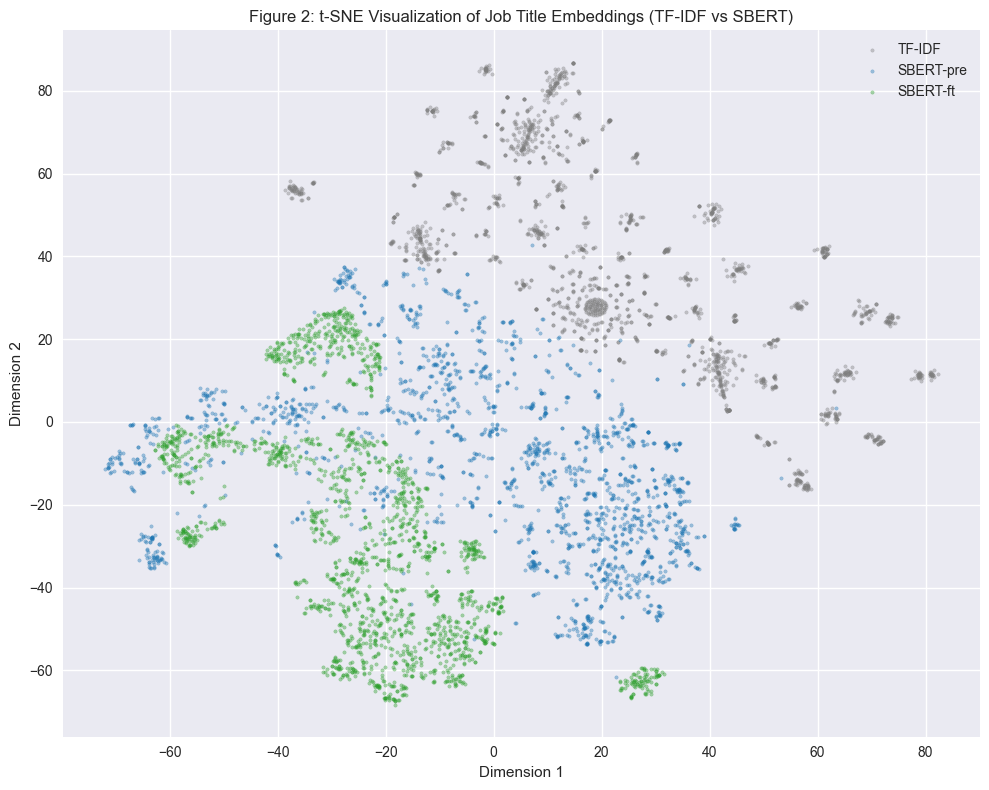

In [115]:
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

# Choose a subset size  
subset_size = 2000
subset_size = min(subset_size, tfidf_matrix.shape[0])  # safety

# Subset embeddings
tfidf_subset = tfidf_matrix[:subset_size]          # sparse (scipy matrix)
pre_subset   = emb_pre_norm[:subset_size]          # (subset_size, d_pre)
ft_subset    = emb_ft_norm[:subset_size]           # (subset_size, d_ft)

# 1) Reduce TF-IDF to 50 dimensions
svd_tfidf = TruncatedSVD(n_components=50, random_state=42)
tfidf_reduced = svd_tfidf.fit_transform(tfidf_subset)

# 2) Reduce SBERT embeddings to 50 dimensions with a shared transform
svd_sbert = TruncatedSVD(n_components=50, random_state=42)
pre_reduced = svd_sbert.fit_transform(pre_subset)
ft_reduced  = svd_sbert.transform(ft_subset)  # same projection as pre_reduced

# 3) Stack all reduced embeddings
all_emb = np.vstack([tfidf_reduced, pre_reduced, ft_reduced])
labels = (["TF-IDF"] * subset_size
          + ["SBERT-pre"] * subset_size
          + ["SBERT-ft"] * subset_size)

# 4) t-SNE on reduced embeddings
# NOTE: removed n_iter to avoid TypeError on older sklearn versions
tsne = TSNE(
    n_components=2,
    perplexity=40,
    learning_rate=200,
    init="random",
    random_state=42,
)
emb_2d = tsne.fit_transform(all_emb)

# 5) Plot
plt.figure(figsize=(10, 8))

labels_arr = np.array(labels)
for model_name, color in [("TF-IDF", "tab:gray"),
                          ("SBERT-pre", "tab:blue"),
                          ("SBERT-ft", "tab:green")]:
    mask = labels_arr == model_name
    plt.scatter(
        emb_2d[mask, 0],
        emb_2d[mask, 1],
        s=6,
        alpha=0.4,
        label=model_name,
        c=color
    )

plt.title("Figure 2: t-SNE Visualization of Job Title Embeddings (TF-IDF vs SBERT)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.tight_layout()
plt.show()

### Graph 2: Bar chart of SOC accuracy for unseen queries

In [26]:
# Re-use soc_accuracy_per_query from above

def mean_soc_accuracy(acc_dict):
    return float(np.mean(list(acc_dict.values())))

acc_tfidf = soc_accuracy_per_query(tfidf_retrieve_similar)
acc_pre   = soc_accuracy_per_query(sbert_pre_retrieve_similar)
acc_ft    = soc_accuracy_per_query(sbert_ft_retrieve_similar)

score_tfidf = mean_soc_accuracy(acc_tfidf)
score_pre   = mean_soc_accuracy(acc_pre)
score_ft    = mean_soc_accuracy(acc_ft)

print("Mean SOC major-group accuracy on unseen queries:")
print("TF-IDF   :", score_tfidf)
print("SBERT-pre:", score_pre)
print("SBERT-ft :", score_ft)

Mean SOC major-group accuracy on unseen queries:
TF-IDF   : 0.22000000000000003
SBERT-pre: 0.5
SBERT-ft : 0.5


In [113]:
# Table 1 is the combination of "SOC Accuracy", "P@10", "MRR")
table1 = pd.DataFrame({
    "Model": ["TF-IDF", "SBERT-pre", "SBERT-ft"],
    "RQ1: SOC Accuracy": [score_tfidf, score_pre, score_ft],
    "RQ2: P@10":  [p_tfidf,  p_pre,      p_ft],
    "RQ2: MRR":   [mrr_tfidf, mrr_pre,   mrr_ft]
})
print("Table 1")
display(table1)

Table 1


,Model,RQ1: SOC Accuracy,RQ2: P@10,RQ2: MRR
0,TF-IDF,0.22,0.020477,0.004278
1,SBERT-pre,0.50,0.075323,0.016413
2,SBERT-ft,0.50,0.067132,0.016786


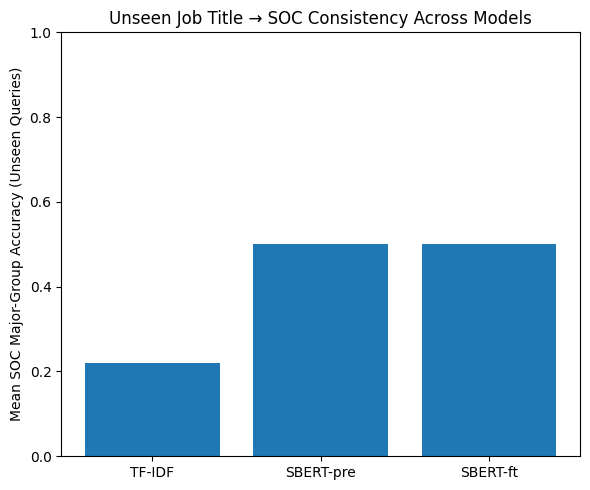

In [27]:
models = ["TF-IDF", "SBERT-pre", "SBERT-ft"]
scores = [score_tfidf, score_pre, score_ft]

plt.figure(figsize=(6, 5))
plt.bar(models, scores)
plt.ylabel("Mean SOC Major-Group Accuracy (Unseen Queries)")
plt.ylim(0, 1)
plt.title("Unseen Job Title → SOC Consistency Across Models")
plt.tight_layout()
plt.show()

# Pipeline Diagram Again:

```mermaid
flowchart LR
    A["Load O*NET Alt Titles Dataset"] --> B["Clean & Normalize Titles"]
    B --> C["Train/Val/Test Split by SOC Code"]

    C --> D1["TF-IDF Vectorizer"]
    C --> D2["SBERT Pretrained Embeddings"]
    C --> D3["SBERT Fine-tuning on Title Pairs"]

    D1 --> E1["FAISS / Matrix Index"]
    D2 --> E2["FAISS Index"]
    D3 --> E3["FAISS Index"]

    E1 --> F1["Seen→Canonical Eval (P@10, MRR)"]
    E2 --> F1
    E3 --> F1

    E1 --> F2["Unseen to Seen SOC Evaluation"]
    E2 --> F2
    E3 --> F2

    F2 --> G1["Failure Case Analysis"]
    F2 --> G2["Ablation: Negatives, Epochs, Batch Size"]

    G2 --> H1["Compute & Report Runtime (Encoding + Evaluation)"]
    H1 --> I["Tables & Graphs (Tables 1-4, t-SNE, SOC Bar Plot)"]
    I --> J["Results & Discussion"]
